In [1]:
%matplotlib widget

import rioxarray
import xarray as xr
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import datetime
from eomaps import Maps

In [2]:
sig0_dc = xr.open_dataset('data/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E054N006T3/SIG0_20180228T043908__VV_D080_E054N006T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.nc')
hparam_dc = xr.open_dataset('data/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R3/EQUI7_EU020M/E054N006T3/D080.nc')
plia_dc = xr.open_dataset('data/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E054N006T3/PLIA-TAG-MEAN_20200101T000000_20201231T235959__D080_E054N006T3_EU020M_V01R03_S1IWGRDH.nc')
RANGE = np.arange(-30, 0, 0.1)

In [3]:
sig0_dc['id'] = (('y', 'x'), np.arange(sig0_dc.SIG0.size).reshape(sig0_dc.SIG0.shape))
hparam_dc['id'] = (('y', 'x'), np.arange(sig0_dc.SIG0.size).reshape(sig0_dc.SIG0.shape))
plia_dc['id'] = (('y', 'x'), np.arange(sig0_dc.SIG0.size).reshape(sig0_dc.SIG0.shape))

In [4]:
def calc_water_prior(id, x=RANGE):
    point = plia_dc.where(plia_dc.id == id, drop=True)
    wbsc_mean = point.PLIA * -0.394181 + -4.142015
    wbsc_std = 2.754041
    return norm.pdf(x, wbsc_mean.to_numpy(), wbsc_std).flatten()

In [5]:
def expected_land_backscatter(data, dtime_str):
    w = np.pi * 2 / 365
    dt = datetime.datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday
    wt = w * t

    M0 = data.M0
    S1 = data.S1
    S2 = data.S2
    S3 = data.S3
    C1 = data.C1
    C2 = data.C2
    C3 = data.C3
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3

def calc_land_prior(id, x=RANGE):
    point = hparam_dc.where(hparam_dc.id == id, drop=True)
    lbsc_mean = expected_land_backscatter(point, '2018-02-01')
    lbsc_std = point.STD
    return norm.pdf(x, lbsc_mean.to_numpy(), lbsc_std.to_numpy()).flatten()

def calc_priors(id, x=RANGE):
    return calc_water_prior(id=id, x=x), calc_land_prior(id=id, x=x)

def plot_priors(id):
    point = sig0_dc.where(sig0_dc.id == id, drop=True).SIG0.to_numpy()
    y1_pdf, y2_pdf = calc_priors(id=id)
    fig, ax = plt.subplots(1, 1)
    ax.plot(RANGE, y1_pdf, 'k-', lw=2)
    ax.vlines(x=point, ymin=0, ymax=np.max((y1_pdf, y2_pdf)), lw=3)
    ax.plot(RANGE, y2_pdf,'r-', lw=5, alpha=0.6)

In [6]:
def calc_posteriors(water_prior, land_prior):
    evidence = (water_prior * 0.5) + (land_prior * 0.5)
    return (water_prior * 0.5) / evidence,  (land_prior * 0.5) / evidence

def bayesian_flood_decision(id, sig0):
    f_post_prob, nf_post_prob = calc_posteriors(*calc_priors(id, sig0))
    out = np.greater(nf_post_prob, f_post_prob)
    return out

def plot_posteriors(id):
    point = sig0_dc.where(sig0_dc.id == id, drop=True).SIG0.to_numpy()
    f_post, nf_post = calc_posteriors(*calc_priors(id=id))
    fig, ax = plt.subplots(1, 1)
    ax.plot(RANGE, f_post, 'k-', lw=2)
    ax.vlines(x=point, ymin=-0.1, ymax=1.1, lw=3)
    ax.plot(RANGE, nf_post,'r-', lw=5, alpha=0.6)

In [7]:
sig0_dc["decision"] = (('y', 'x'), bayesian_flood_decision(sig0_dc.id, sig0_dc.SIG0).reshape(sig0_dc.SIG0.shape))
sig0_dc["decision"] = sig0_dc.decision.where(sig0_dc.SIG0.notnull())
sig0_dc["decision"] = sig0_dc.decision.where(sig0_dc.decision==0)

In [8]:
# initialize a map on top
m = Maps(ax=122, layer="data")
m.add_feature.preset.ocean()
m.add_feature.preset.coastline()

# initialize 2 matplotlib plot-axes below the map
ax_upper = m.f.add_subplot(221)
ax_upper.set_ylabel("likelihood")
ax_upper.set_xlabel("sigma")

ax_lower = m.f.add_subplot(223)
ax_lower.set_ylabel("probability")
ax_lower.set_xlabel("sigma")

# add map
m2 = m.new_layer(layer="map")
m2.add_wms.OpenStreetMap.add_layer.default()

# -------- assign data to the map and plot it
m.set_data(data=sig0_dc, x="x", y="y", parameter="decision", crs=sig0_dc.spatial_ref.crs_wkt)
m.plot_map()
m.show_layer("map", ("data", 0.5))

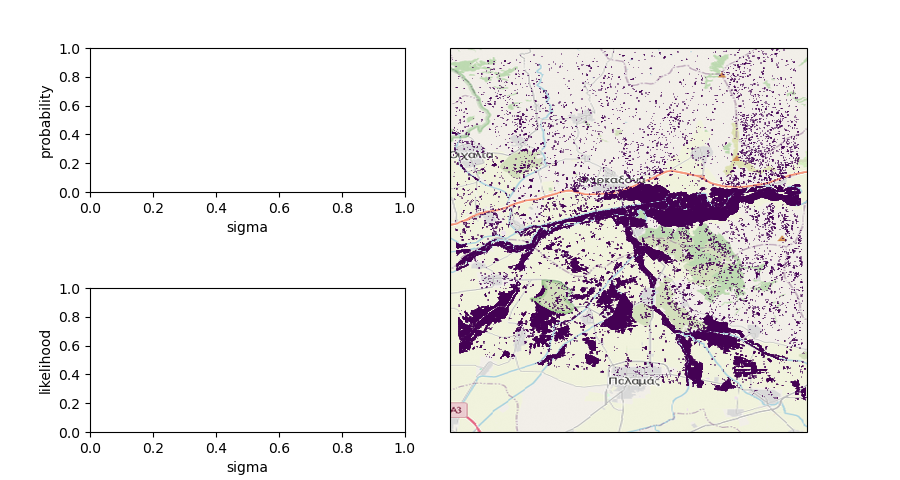

In [9]:
# -------- define a custom callback function to update the plots
def update_plots(ID, **kwargs):
    
    # get the data
    value = sig0_dc.where(sig0_dc.id == ID, drop=True).SIG0.to_numpy()
    y1_pdf, y2_pdf = calc_priors(ID)
    f_post, nf_post = calc_posteriors(*calc_priors(ID))

    # plot the lines and vline
    (water,) = ax_upper.plot(RANGE, y1_pdf, 'k-', lw=2)
    (land,) = ax_upper.plot(RANGE, y2_pdf,'r-', lw=5, alpha=0.6)
    value_left = ax_upper.vlines(x=value, ymin=0, ymax=np.max((y1_pdf, y2_pdf)), lw=3)

    (f,) = ax_lower.plot(RANGE, f_post, 'k-', lw=2)
    (nf,) = ax_lower.plot(RANGE, nf_post,'r-', lw=5, alpha=0.6)
    value_right = ax_lower.vlines(x=value, ymin=-0.1, ymax=1.1, lw=3)

    # re-compute axis limits based on the new artists
    ax_upper.relim()
    # ax_lower.relim()
    ax_upper.autoscale()
    # ax_lower.autoscale()

    # add all artists as "temporary pick artists" so that they
    # are removed when the next datapoint is selected
    for a in [water, land, value_right, nf, f, value_left]:
        m.cb.pick.add_temporary_artist(a)

m.cb.pick.attach(update_plots)
m.cb.pick.attach.mark(permanent=False, buffer=1, fc="none", ec="r")
m.cb.pick.attach.mark(permanent=False, buffer=2, fc="none", ec="r", ls=":")

m.apply_layout(
    {
        "figsize": [9, 4.8],
        "0_map": [0.5, 0.1, 1, 0.8],
        "1_": [0.1, 0.1, 0.35, 0.3],
        "2_": [0.1, 0.6, 0.35, 0.3],
    }
)
m.show()